In [2]:
import jsonlines as jsonl
from datasets import Dataset, load_dataset

dataset = load_dataset("shahules786/orca-best")
dataset = dataset["train"]

Found cached dataset parquet (/home/diwank/.cache/huggingface/datasets/shahules786___parquet/shahules786--orca-best-6e39a9e725476d70/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
dataset[0]

{'cluster': {'samples': [{'input': 'Definition: You are given a statement written in Kannada. Choose the most logical word from the given 4 options which can be used to replace the <MASK> token in the statement. Output the word from the correct option .\nInput: Statement: ವೃತ್ತಿ ಜೀವನದ ಉತ್ತುಂಗದ ದಿನಗಳಲ್ಲೇ ವೈವಾಹಿಕ ಜೀವನಕ್ಕೆ ಕಾಲಿರಿಸಿದ ವನಿತಾ ನಿರ್ದೇಶಕ <MASK> ಅವರ ಶ್ರೇಷ್ಠ ಚಿತ್ರ ನಾಗಮಂಡಲ(೧೯೯೭)ದಲ್ಲಿನ ಪ್ರಮುಖ ಪಾತ್ರವೊಂದರಲ್ಲಿ ಅಭಿನಯಿಸುವ ಮೂಲಕ ಬೆಳ್ಳಿತೆರೆಗೆ ಮರಳಿದರು. ಆ ನಂತರದಲ್ಲಿ ಪ್ರೀತ್ಸೆ(೨೦೦೦), ಮೆಜೆಸ್ಟಿಕ್(೨೦೦೨), ಏಕಾಂಗಿ(೨೦೦೨), ಗಣೇಶ(೨೦೦೭) ಮತ್ತು ಹುಡುಗರು(೨೦೧೧) ಮುಂತಾದ ಚಿತ್ರಗಳಲ್ಲಿ ಪೋಷಕ ಪಾತ್ರಗಳಲ್ಲಿ ಕಾಣಿಸಿಕೊಂಡು ಉತ್ತಮ ಅಭಿನಯ ನೀಡಿದ್ದಾರೆ.\n\n Option A: ಅಂಬರೀಶ್\n\n Option B: ಟಿ.ಎಸ್.ನಾಗಾಭರಣ\n\n Option C: ದೇವರಾಜ್\u200c\n\n Option D: ಕಾಶಿನಾಥ್\nOutput:',
    'output': 'ಟಿ.ಎಸ್.ನಾಗಾಭರಣ\n\nI used the definition provided and analyzed the statement in Kannada. It talks about a female artist returning to the silver screen with the movie "Nagamandala" directed by the person with the <MASK> token. From the given options A, B, C, a

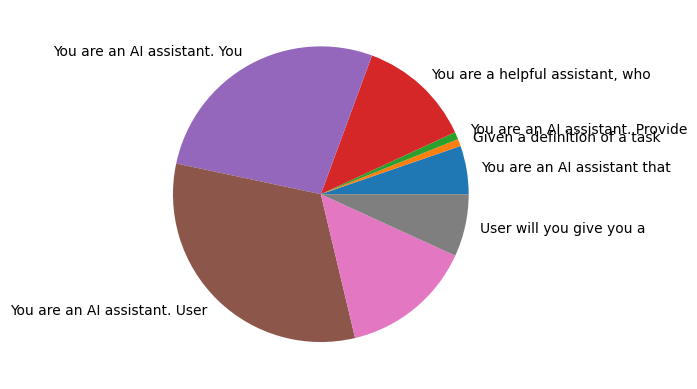

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# if using a Jupyter notebook, includue:
%matplotlib inline

instruction_samples = [
    (" ".join(row["instruction"].split(" ")[:6]), row["num_samples"])
    for row in dataset
    if row["num_samples"] > 100
]

instr_sample_map = {}

for instr, num in instruction_samples:
    if instr in instr_sample_map:
        instr_sample_map[instr] += num
    else:
        instr_sample_map[instr] = num

labels, y = instr_sample_map.keys(), instr_sample_map.values()
plt.pie(list(y), labels=list(labels))
plt.show() 

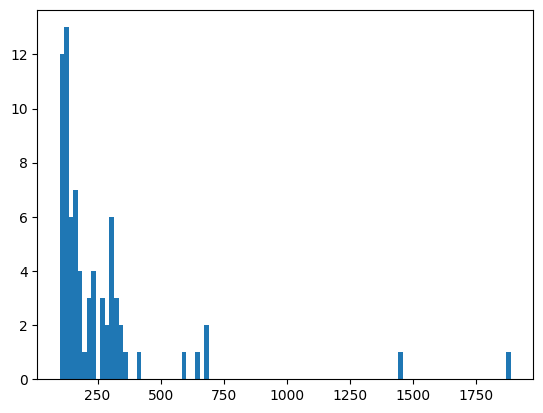

In [20]:
lens = np.array(dataset["num_samples"])
lens = lens[lens > 100]
plt.hist(lens, 100)
plt.show()

In [21]:
len(dataset)

328906

In [22]:
import random

def take_one_each(row):
    instruction = row["instruction"]
    samples = row["cluster"]["samples"]
    sample = random.choice(samples)

    return {
        "instruction": instruction,
        **sample
    }

dataset = dataset.map(take_one_each)

Map:   0%|          | 0/328906 [00:00<?, ? examples/s]

In [23]:
make_chatml = lambda name, role, content: dict(
    name=name, role=role, content=content,
)

system = lambda name, content: make_chatml(
    role="system",
    name=name,
    content=content,
)

situation = lambda content: system(name="situation", content=content)
thought = lambda content: system(name="thought", content=content)
information = lambda content: system(name="information", content=content)
me = lambda content, name=None: make_chatml(
    role="assistant",
    content=content,
    name=name,
)

person = lambda content, name=None: make_chatml(
    role="user",
    content=content,
    name=name,
)

def entry_to_chatml(row):
    instruction = row["instruction"]
    input = row["input"]
    output = row["output"]
    
    # Start preparing chatml
    situation_content = (
        "User is talking to an AI Large Language Model."
        "The AI must follow the instructions given below to the letter and help the User with their request."
    )
    
    chatml = [
        situation(situation_content),
        information(f"Instructions:\n\n{instruction}"),
        person(input, name="User"),
        me(output, name="AI"),
    ]

    return dict(chatml=chatml)

In [24]:
dataset = dataset.map(entry_to_chatml).remove_columns(list(set(dataset.column_names) - {"chatml"}))

Map:   0%|          | 0/328906 [00:00<?, ? examples/s]

In [25]:
dataset.push_to_hub("diwank/orca_best_one_each-chatml", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/165 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/165 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]